In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import os

from nilearn.maskers import NiftiMasker
from brainextractor import BrainExtractor


import nibabel as nib

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import pickle


In [7]:
fmri_data = []
events = []
sub = 1

tr = 0.867

anat_img = nib.load(f"../data/bids/sub-0{sub}/ses-01/anat/sub-0{sub}_ses-01_T1w.nii.gz")

for ses in range(1,5):
    for run in range(1,5):


        file = f"../data/derivatives/sub-0{sub}/ses-0{ses}/func/sub-0{sub}_ses-0{ses}_task-video_run-{run}_motion-corrected_bold.nii.gz"

        if not os.path.isfile(file):
            continue

        fmri_img = nib.load(file)
        fmri_data.append(fmri_img)

        events_path = f"../data/bids/sub-0{sub}/ses-0{ses}/func/sub-0{sub}_ses-0{ses}_task-video_run-{run}_events.tsv"
        events_df = pd.read_csv(events_path, sep='\t')
        events.append(events_df)

print(len(fmri_data))
print(len(events))

11
11


0it [00:00, ?it/s]

A 'modulation' column was found in the given events data and is used.


1it [00:06,  6.95s/it]

A 'modulation' column was found in the given events data and is used.


2it [00:12,  6.18s/it]

A 'modulation' column was found in the given events data and is used.


3it [00:20,  7.13s/it]

A 'modulation' column was found in the given events data and is used.


4it [00:29,  7.58s/it]

A 'modulation' column was found in the given events data and is used.


5it [00:36,  7.60s/it]

A 'modulation' column was found in the given events data and is used.


6it [00:50,  9.67s/it]

A 'modulation' column was found in the given events data and is used.


7it [00:58,  9.28s/it]

A 'modulation' column was found in the given events data and is used.


8it [01:09,  9.56s/it]

A 'modulation' column was found in the given events data and is used.


9it [01:21, 10.53s/it]

A 'modulation' column was found in the given events data and is used.


10it [01:31, 10.34s/it]

A 'modulation' column was found in the given events data and is used.


11it [01:40,  9.11s/it]


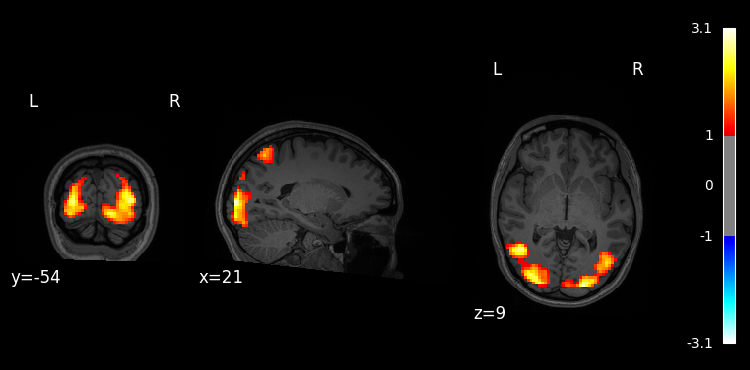

In [4]:
from nilearn import plotting, image
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")


frame_times = np.arange(fmri_data[0].shape[3]) * tr
z_maps = []

for i, fmri_img in tqdm(enumerate(fmri_data)):

    events_temp = events[i].copy()
    events_temp['duration'] = 3
    # print(events_temp.head())
    # Create the design matrix
    design_matrix = make_first_level_design_matrix(frame_times, events_temp, hrf_model='glover', drift_model='cosine', high_pass=0.01)
    # plotting.plot_design_matrix(design_matrix)
    # plotting.show()

    scaler = StandardScaler()

    events_temp['modulation'] = scaler.fit_transform(events_temp[['disgust']])
    design_matrix_temp = make_first_level_design_matrix(frame_times, events_temp, hrf_model='glover', drift_model=None)
    # plotting.plot_design_matrix(design_matrix_temp)
    # plotting.show()

    design_matrix['modulation'] = design_matrix_temp['dummy']
    # plotting.plot_design_matrix(design_matrix)
    # plotting.show()

    # Fit the GLM
    fmri_glm = FirstLevelModel(t_r=tr, noise_model='ar1', standardize=True, smoothing_fwhm=6)
    fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrix)

    # Specify the contrast
    # Example: contrast modulation effect
    contrast = np.zeros(design_matrix.shape[1])
    contrast[design_matrix.columns.get_loc('modulation')] = 1

    # Compute the contrast
    z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')
    z_maps.append(z_map)

# Plot the result
plotting.plot_stat_map(image.mean_img(z_maps), bg_img=anat_img, colorbar=True, threshold=1, draw_cross=False)
plotting.show()

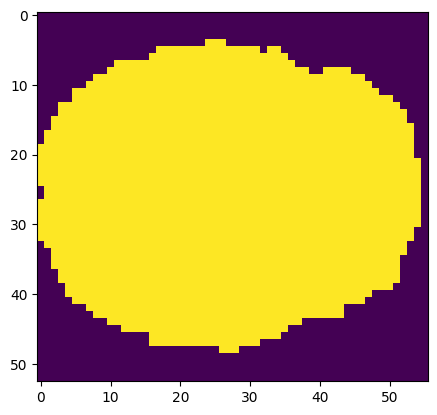

In [8]:


target_output_path = f"output/sub-{sub:02}"


if os.path.isfile(f"{target_output_path}/mask.nii.gz"):
    mask_img = nib.load(f"{target_output_path}/mask.nii.gz")
else:

    bet = BrainExtractor(img=anat_img)
    bet.run()


    if not os.path.exists(target_output_path):
        os.makedirs(target_output_path)
        
    bet.save_mask(f"{target_output_path}/mask.nii.gz")

    mask = bet.compute_mask()
    mask_img = nib.nifti1.Nifti1Image(mask, affine=anat_img.affine)
    # plt.imshow(mask_img.get_fdata()[...,80])
    # plt.show()



mask_img_resampled = image.resample_to_img(mask_img, fmri_data[0].slicer[...,0], interpolation="nearest")
plt.imshow(mask_img_resampled.get_fdata()[...,25])
plt.show()

In [9]:




masker = NiftiMasker(
    standardize=True,
    detrend=True,
    smoothing_fwhm=6,
    mask_img=mask_img_resampled
    )

masker.fit(fmri_data[0])

NiftiMasker(detrend=True,
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x00000130DEA42C40>,
            smoothing_fwhm=6, standardize=True)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [01:31<00:00,  8.30s/it]


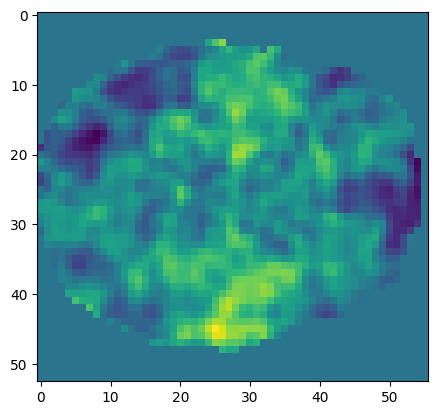

In [10]:
fmri_masked = []


for img in tqdm(fmri_data):

    masked_data = masker.transform(img)
    fmri_masked.append(masked_data)

plt.imshow(masker.inverse_transform(fmri_masked[1]).get_fdata()[:,:,25,50])


In [11]:
from sklearn.mixture import GaussianMixture

def binarize_data(data):
    ## Binarize data

    # Step 3: Fit a Gaussian Mixture Model (GMM)
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(data.reshape(-1, 1))
    threshold = np.mean(gmm.means_)

    # Step 4: Binarize the data using the threshold
    binary_data = (data > threshold).astype(int)

    # Print the threshold for reference
    # print(f'Threshold: {threshold}')
    return binary_data


In [12]:
fmri_peaks = []
ratings = {
    "fear": [],
    "disgust": [],
    "cute": []
}

for i, data in enumerate(fmri_masked):

    peak_frames = np.zeros((events[i].shape[0], data.shape[1]))

    onset_times = events[i]["onset"].to_numpy()
    for var in ["fear", "disgust", "cute"]:
        ratings[var].append(binarize_data(events[i][var].to_numpy()))

    if i < 4:
        peak_frames = peak_frames[:198,:]
        onset_times = onset_times[:198]
        for var in ["fear", "disgust", "cute"]:
            ratings[var][i] = ratings[var][i][:198]

    for j, onset_time in enumerate(onset_times):

        # onset_in_tr = round(onset_time / tr)
        peak_in_tr = round((onset_time + 6) / tr)
        fmri_avg = np.mean(data[peak_in_tr - 1:peak_in_tr + 2,:], axis=0)
        peak_frames[j,:] = fmri_avg

    fmri_peaks.append(peak_frames)


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score


def compute_model(fmri_peaks, ratings, full=False, write=False, var=None):


    # model = LogisticRegression(C=200, penalty='l1', solver='liblinear')#, class_weight = {0: 1, 1: 5})
    model = LogisticRegression(C=1.0, l1_ratio=0.5, penalty='elasticnet', solver='saga')#, class_weight = {0: 1, 1: 5})
    # model = LogisticRegression(C=1.0, penalty='elasticnet', solver='liblinear')#, class_weight = {0: 1, 1: 5})
    # model = LogisticRegression()


    # X = pca.transform(np.vstack(fmri_peaks))
    # y = np.concatenate(ratings)

    cv_scores = []
    y_pred_all = []
    y_pred_proba_all = []
    roc_auc_scores = []

    r_scores = []

    pca = PCA(n_components = 200)

    if full:

        if not var:
            raise Exception("Variable name required for full model option.")

        X = pca.fit_transform(np.vstack(fmri_peaks))
        y = np.concatenate(ratings)



        model.fit(X, y)

        # plt.plot(model.coef_[0,:])
        # plt.show()


        if write:

            with open(f"{target_output_path}/masker_model.pkl","wb") as f:
                pickle.dump(masker, f)

            with open(f"{target_output_path}/pca_model.pkl","wb") as f:
                pickle.dump(pca, f)

            with open(f"{target_output_path}/{var}_model.pkl","wb") as f:
                pickle.dump(model, f)

            

        return model, pca
        

    for i in range(len(fmri_peaks)):

        # pca.fit(np.vstack(fmri_masked[:i] + fmri_masked[i+1:]))
        # X = pca.transform(np.vstack(fmri_peaks[:i] + fmri_peaks[i+1:]))
        X = pca.fit_transform(np.vstack(fmri_peaks[:i] + fmri_peaks[i+1:]))
        y = np.concatenate(ratings[:i] + ratings[i+1:])
        
        model.fit(X, y)

        # Make predictions
        X_test = pca.transform(fmri_peaks[i])
        y_test = ratings[i]

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)


        r = np.corrcoef(y_test, y_pred_proba)[0,1]
        r_scores.append(r)

        y_pred_all.append(y_pred)
        y_pred_proba_all.append(y_pred_proba)
        cv_scores.append(accuracy)
        roc_auc_scores.append(auc)


    # Display cross-validation scores
    # print("Cross-validation accuracy scores:", [ '%.2f' % elem for elem in cv_scores ])
    print("Mean cross-validation accuracy:", '%.2f' % np.mean(cv_scores))


    # Evaluate the model
    print("Confusion Matrix:")
    print(confusion_matrix(np.concatenate(ratings), np.concatenate(y_pred_all)))

    # print("ROC-AUC Score:", roc_auc_score(y, y_pred_proba))
    # print("ROC-AUC Scores:", [ '%.2f' % elem for elem in roc_auc_scores ])
    print("Mean ROC-AUC Score:", '%.2f' % np.mean(roc_auc_scores))

    print(f"Mean R value: {np.mean(r_scores):02}")


    return cv_scores, roc_auc_scores, r_scores



In [14]:
def plot_scores(scores, title):
    max_length = len(scores)#max(len(inner_list) for inner_list in scores)

    means = []
    stds = []

    for i in range(max_length):
        values_at_i = scores[i]# [inner_list[i] for inner_list in data if i < len(inner_list)]
        means.append(np.mean(values_at_i))
        stds.append(np.std(values_at_i))

    for i, inner_list in enumerate(scores):
        plt.plot([i] * len(inner_list), inner_list, 'o', label=f'List {i+1}')

    # Plot the mean line
    plt.plot(range(max_length), means, 'k-', label='Mean')
    plt.fill_between(range(max_length), np.array(means) - np.array(stds), np.array(means) + np.array(stds), color='gray', alpha=0.5, label='Std Dev')

    # Customize x-axis ticks
    # current_ticks = plt.gca().get_xticks()
    # new_ticks = [int(tick + 2) for tick in current_ticks]
    # plt.xticks(new_ticks)

    plt.title(title)
    plt.xlabel("Number of runs")
    plt.ylabel("Cross-validated score")

    # Show the plot
    plt.show()

In [73]:
for var in ["fear", "disgust", "cute"]:

    all_cv_scores = []
    all_roc_scores = []
    all_r_scores = []

    for i in range(10, len(fmri_peaks)):

        cv_scores, roc_scores, r_scores = compute_model(fmri_peaks[:i], ratings[var][:i])
        all_cv_scores.append(cv_scores)
        all_roc_scores.append(roc_scores)
        all_r_scores.append(r_scores)

    # print(f"Var: {var}")
    # print(F"CV scores:")
    # plot_scores(all_cv_scores, "Cross-validated accuracy scores")
    # print(f"AUC scores:")
    # plot_scores(all_roc_scores, "Cross-validated ROC-AUC scores")
    # print(f"AUC scores:")
    # plot_scores(all_r_scores, "Cross-validated r coefficients")

    


KeyboardInterrupt: 

In [137]:
_ = compute_model(fmri_peaks, ratings['fear'])


Mean cross-validation accuracy: 0.69
Confusion Matrix:
[[1260  495]
 [ 181  256]]
Mean ROC-AUC Score: 0.72
Mean R value: 0.32481266546418


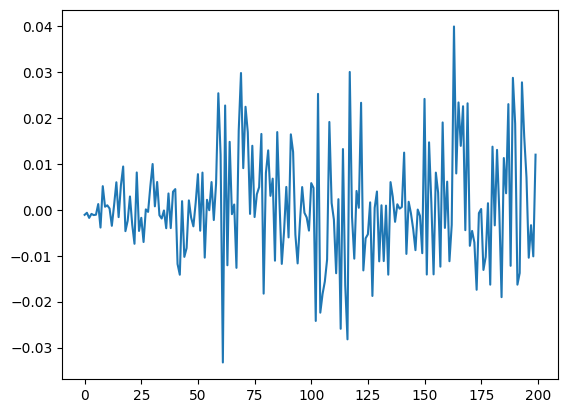

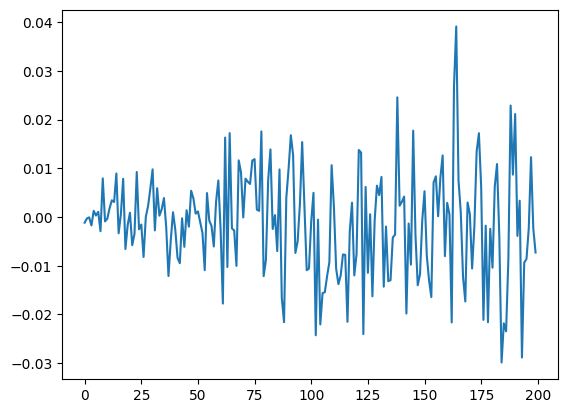

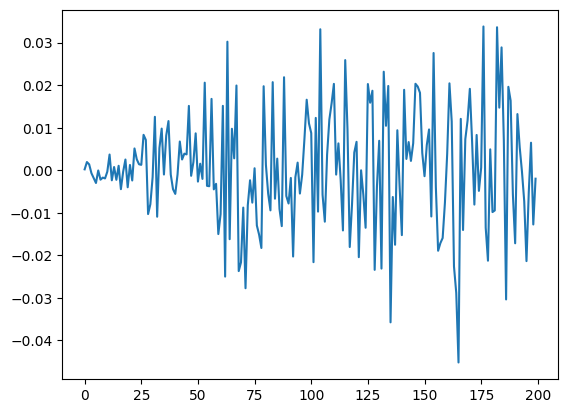

In [138]:
compute_model(fmri_peaks, ratings['fear'], full=True, var="fear")
compute_model(fmri_peaks, ratings['disgust'], full=True, var="disgust")
compute_model(fmri_peaks, ratings['cute'], full=True, var="cute")




In [15]:
model, pca = compute_model(fmri_peaks, ratings['fear'], full=True, write=False, var="fear")

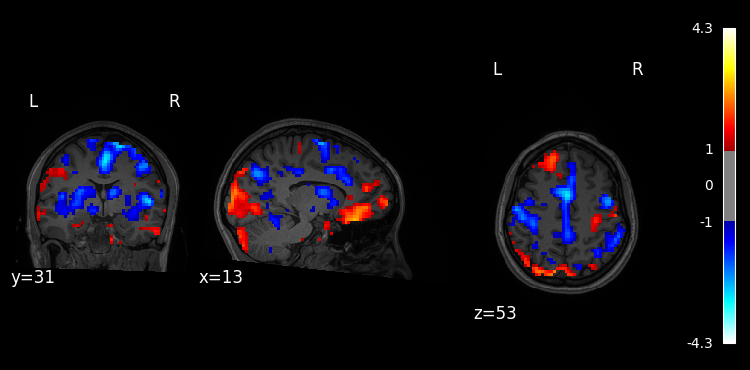

In [30]:
from scipy.stats import zscore
import ants
from nilearn import datasets

beta_map = masker.inverse_transform(zscore(pca.inverse_transform(model.coef_[0,:])))
plotting.plot_stat_map(beta_map, bg_img=anat_img, colorbar=True, threshold=1, draw_cross=False)
plotting.show()


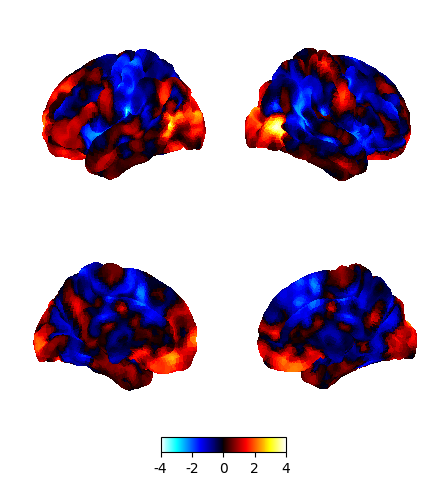

In [31]:

# Align to MNI space

mni_img = ants.image_read(datasets.fetch_icbm152_2009()['t1'])
anat_img_ants = ants.image_read(f"../data/bids/sub-0{sub}/ses-01/anat/sub-0{sub}_ses-01_T1w.nii.gz")
anat_reg = ants.registration(mni_img, anat_img_ants, type_of_transform="SyN")

nib.save(beta_map, "beta_map.nii.gz")
beta_map_ants = ants.image_read("beta_map.nii.gz")

areg = ants.apply_transforms(fixed = mni_img, 
    moving = beta_map_ants, 
    transformlist = anat_reg['fwdtransforms'], 
    interpolator  = 'nearestNeighbor')

ants.image_write(areg, "beta_map_aligned.nii.gz")
beta_map_aligned = nib.load("beta_map_aligned.nii.gz")

plotting.plot_img_on_surf(beta_map_aligned,
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          colorbar=True)
plotting.show()